# Eliciting Priors for a Toy Dataset

In [1]:
import textwrap
import numpy as np

In [2]:
from autoelicit import datasets
from autoelicit import get_llm_elicitation_for_dataset

In [3]:
# datasets which can be loaded for testing
datasets_to_load = {
    "fake_data": datasets.load_fake_data,
    "breast_cancer": datasets.load_breast_cancer,
    "hypothyroid": datasets.load_hypothyroid,
    "sk_diabetes": datasets.load_sk_diabetes,
    "heart_disease": datasets.load_heart_disease,
    "california_housing": datasets.load_california_housing,
    "wine_quality": datasets.load_wine_quality
}

These toy datasets mostly follow the `scikit-learn` toy datasets format.

In [4]:
data = datasets.load_breast_cancer()

In [5]:
data.feature_names

array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error',
       'fractal dimension error', 'worst radius', 'worst texture',
       'worst perimeter', 'worst area', 'worst smoothness',
       'worst compactness', 'worst concavity', 'worst concave points',
       'worst symmetry', 'worst fractal dimension'], dtype='<U23')

In [6]:
data.target_names

array(['benign', 'malignant'], dtype='<U9')

In [7]:
data.data.shape

(569, 30)

We can elicit priors for this data with a task description by defining a system and user prompt for the LLM:

In [8]:
system_role = """
You are a simulator of a logistic regression predictive model 
for predicting breast cancer diagnosis from tumour characteristics.
Here the inputs are tumour characteristics and the output is 
the probability of breast cancer diagnosis from tumour characteristics. 
Specifically, the targets are ['benign', 'malignant'] with mapping 
['benign' = 0, 'malignant' = 1].
With your best guess, you can provide the probabilities of a malignant 
breast cancer diagnosis for the given tumour characteristics.
"""


user_role = """
I am a data scientist with a dataset and the task: predicting breast 
cancer diagnosis from tumour characteristics. 
I would like to use your model to predict the diagnosis of my samples.
I have a dataset that is made up of the following features: {feature_names}.
All of the feature values are standardized using the z-score.
By thinking about how each feature might be related to a diagnosis of 
['benign', 'malignant'] , and whether each feature is positively or 
negatively correlated with the outcome of 
['benign' = 0, 'malignant' = 1], 
I would like you to guess the 
mean and standard deviation for a normal distribution prior for each feature
for a logistic regression model can be used for
predicting breast cancer diagnosis from tumour characteristics.
Please respond with a JSON object with the feature names as keys 
and a nested dictionary of mean and standard deviation as values.
A positive mean indicates a positive correlation with the outcome,
a negative mean indicates a negative correlation with the outcome,
whilst a small standard deviation indicates that you are confident in your guess.
Please only respond with a JSON, no other text.
"""

And by defining the LLM class. The `GPTOutputs` class can be used with OpenAI's API. This is a simple class, which is available in the `gpt` submodule, along with its documentation. The code for this class is:

In [9]:
import os
import numpy as np
from openai import OpenAI

class LLMOutputs(object):
    """
    Base class that allows you to interact with a language model.
    """

class GPTOutputs(LLMOutputs):
    def __init__(
        self,
        model_id = "gpt-4-turbo",
        temperature = 1.0,
        result_args = {},
        rng = None,
    ):
        self.client = OpenAI(api_key=os.environ["OPENAI_API_KEY"])
        self.model_id = model_id
        self.temperature = temperature
        self.result_args = result_args
        self.rng = np.random.default_rng() if rng is None else rng

    def get_result(self, messages) -> str:

        response = self.client.chat.completions.create(
            model=self.model_id,
            messages=messages,
            temperature=self.temperature,
            seed=int(self.rng.integers(1e9)),
            **self.result_args,
        )

        return response.choices[0].message.content


Any object with a `.get_result(messages)` method can be used to elicit a prior. In the `gpt` submodule we have three other LLM classes that correspond to Llama, Qwen, and DeepSeek.

In [10]:
from autoelicit.gpt import (
    GPTOutputs, LlamaOutputs, QwenOutputs, DeepSeekOutputs
)

In [11]:
client = GPTOutputs(
    model_id="gpt-3.5-turbo",
    # setting the temperature of the model
    temperature=0.1,
    # when performing prior elicitation with LLMs, we 
    # must specify that we want a json object returned.
    result_args=dict(
        response_format={"type": "json_object"},
    ),
    rng=np.random.default_rng(42),
)

This class is a thin wrapper for an LLM that simply unifies the method for getting a response:

In [12]:
response = client.get_result(
    messages=[
        {
            "role": "system",
            "content": "You are an LLM built by OpenAI."
        },
        {
            "role": "user",
            "content": "Can I see your identification as a JSON?"
        }
    ]
)

In [13]:
print(response)

{
    "name": "Language Model",
    "manufacturer": "OpenAI",
    "model": "LLM",
    "version": "1.0.0"
}


Since we set the `response_format` as `'json_object'`, our LLM will only return JSON objects. This is an OpenAI option that we make use of to elicit priors. For other language models, we might have to do post-processing to make sure the output is JSON.

Our `LlamaOutputs`, `QwenOutputs`, `DeepSeekOutputs` classes also support `result_args=dict(response_format={"type": "json_object"})`


We can also use these wrappers to rephrase our task descriptions:

In [14]:
from autoelicit.gpt import rephrase_task_description

In [15]:
new_text = rephrase_task_description(
    client=GPTOutputs(
        model_id="gpt-4o-mini-2024-07-18",
        temperature=1.0,
    ),
    base_text=user_role,
    n_rephrasings=3,
)

In [16]:
print(
    "\n".join(textwrap.wrap(new_text, width=70, replace_whitespace=False))
)

I am a data scientist working with a dataset aimed at predicting
breast cancer diagnoses based on tumor characteristics. I would like
to utilize your model to forecast the diagnosis for my samples. My
dataset includes the following features: {feature_names}. All feature
values have been standardized using the z-score method. By considering
how each feature might relate to a diagnosis of ['benign',
'malignant'] and whether each one shows a positive or negative
correlation with the outcomes of ['benign' = 0, 'malignant' = 1], I
would appreciate it if you could estimate the mean and standard
deviation for a normal distribution prior for each feature that could
be applied in a logistic regression model for predicting breast cancer
diagnosis from tumor characteristics. Please return your response as a
JSON object with feature names as keys and a nested dictionary
containing mean and standard deviation as values. A positive mean
suggests a positive correlation with the outcome, a negative me

In [12]:
user_roles = [
"""
I am a data scientist working with a dataset aimed at predicting
breast cancer diagnoses based on tumor characteristics. I would like
to utilize your model to forecast the diagnosis for my samples. My
dataset includes the following features: {feature_names}. All feature
values have been standardized using the z-score method. By considering
how each feature might relate to a diagnosis of ['benign',
'malignant'] and whether each one shows a positive or negative
correlation with the outcomes of ['benign' = 0, 'malignant' = 1], I
would appreciate it if you could estimate the mean and standard
deviation for a normal distribution prior for each feature that could
be applied in a logistic regression model for predicting breast cancer
diagnosis from tumor characteristics. Please return your response as a
JSON object with feature names as keys and a nested dictionary
containing mean and standard deviation as values. A positive mean
suggests a positive correlation with the outcome, a negative mean
indicates a negative correlation, and a small standard deviation
reflects your confidence in your estimate. Please provide only a JSON
response, without any additional text.
""",

"""
I am a data scientist
with a dataset tasked with predicting breast cancer diagnoses from
tumor characteristics. I would like to apply your model to forecast
the diagnosis of my samples. The dataset I have includes the following
features: {feature_names}. All feature values have been standardized
using the z-score. By evaluating how each feature may relate to a
diagnosis of ['benign', 'malignant'] and whether each feature
correlates positively or negatively with the diagnosis outcomes
['benign' = 0, 'malignant' = 1], I request that you estimate the mean
and standard deviation for a normal distribution prior for each
feature to be used in a logistic regression model for predicting
breast cancer diagnosis based on tumor characteristics. Kindly respond
with a JSON object where the feature names are the keys, and the
corresponding mean and standard deviation are nested as values. A
positive mean indicates a positive correlation with the outcome, while
a negative mean signals a negative correlation; furthermore, a small
standard deviation indicates a high level of confidence in your
guesses. Please limit your response to JSON only, without any other
information.
""",

"""
As a data scientist, my current task involves using
a dataset to predict breast cancer diagnoses from tumor
characteristics. I am seeking to employ your model to determine the
diagnosis of my samples. The dataset consists of the following
features: {feature_names}. All values of the features are standardized
using the z-score method. Considering how each feature might correlate
with a diagnosis of ['benign', 'malignant'] and whether they are
positively or negatively associated with the outcomes of ['benign' =
0, 'malignant' = 1], I would like you to provide estimates for the
mean and standard deviation for a normal distribution prior for each
feature suitable for a logistic regression model dedicated to
predicting breast cancer diagnosis from tumor characteristics. Please
reply with a JSON object where the keys are the feature names, and the
values are nested dictionaries of mean and standard deviation. A
positive mean suggests a positive correlation with the outcome, while
a negative mean implies a negative correlation, and a smaller standard
deviation reflects greater confidence in your estimation. Please
respond with only JSON, avoiding any additional text.
"""
]

We recommend to do the same with the system role so that we can take a product over them, but we will not do this for ease of demonstration.

In [13]:
system_roles = [system_role]

Performing AutoElicit for a dataset can then be as simple as:

In [14]:
priors = get_llm_elicitation_for_dataset(
    client=client,
    # we would usually use multiple system and user roles
    # so that we can build a mixture of the priors elicited.
    system_roles=system_roles,
    user_roles=user_roles,
    # this will replace the {feature_names}
    # in the prompts and also allow us to correctly
    # convert the JSON response into a numpy array 
    # of means and stds
    feature_names=data.feature_names.tolist(),
    # prints progress, each prior elicited, and the prompts
    # used to elicit the priors
    verbose=False
)

In [15]:
priors.shape

(3, 31, 2)

This is our prior distribution with shape `(mixture_components, features, (mean, std))`.

Many methods can then be used to perform Bayesian inference using this prior and observations. In our published work, we use `pymc`, but `blackjax` could also be used. To ensure this package is lightweight, both of these packages are not part of the requirements.

Instead, we can use numpy to visualise the parameter histograms in the first 10 features.

In [16]:
prior_samples = np.random.normal(
    loc=priors[:, :, 0],
    scale=priors[:, :, 1],
    # 100 samples of the 3 mixture components for each feature
    size=(1000, 3, 31)
)

In [17]:
prior_samples.shape

(1000, 3, 31)

We will use `matplotlib` and `seaborn` to graph the samples. This is not installed by this package, so make sure it is if you're running the below!

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from autoelicit.plotting import graph_theme

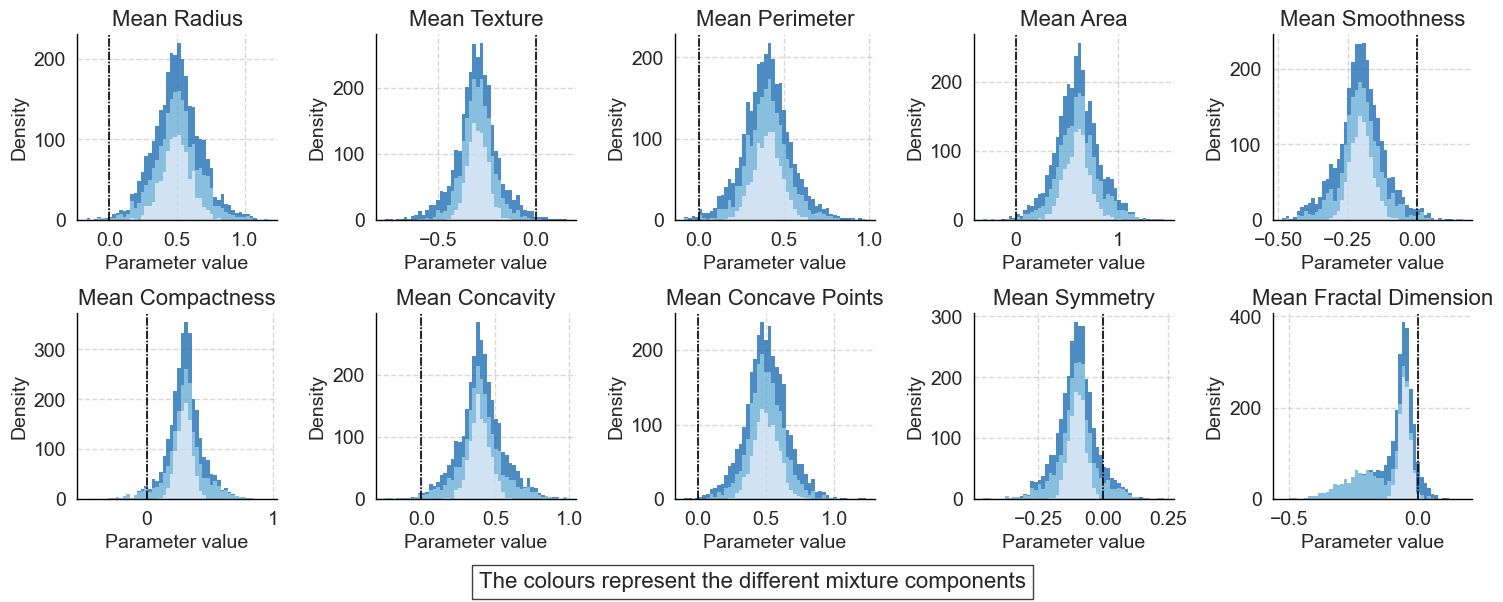

In [34]:
n_features_to_plot = 10

n_rows = 2
n_columns = 5

hist_kwargs = dict(
    bins=50,
    linewidth=0.0,
    stacked=True,
    alpha=0.8,
    color=sns.color_palette("Blues", n_colors=prior_samples.shape[1])
)

fontsize = 14
title_fontsize = 16
with graph_theme():
    fig, axes = plt.subplots(
        n_rows, n_columns, figsize=(3*n_columns, 3*n_rows)
    )

    for feature, ax in zip(
        range(1, n_features_to_plot + 1), # not drawing the intercept
        axes.ravel()
    ):
        ax.hist(
            prior_samples[:, :, feature],
            **hist_kwargs
        )
        ax.set_title(data.feature_names[feature-1].title(), fontsize=title_fontsize)
        ax.set_xlabel("Parameter value", fontsize=fontsize)
        ax.set_ylabel("Density", fontsize=fontsize)
        ax.tick_params("both", labelsize=fontsize)
        ax.axvline(
            x=0.0, 
            linestyle=(0,(5,1,1,1)), 
            color="xkcd:black",
        )

    fig.text(
        x=0.5, y=0.02, 
        s="The colours represent the different mixture components",
        verticalalignment="bottom", horizontalalignment="center", 
        fontsize=title_fontsize,
        bbox=dict(
            facecolor='white', 
            alpha=0.75, 
            edgecolor='black',
            linewidth=1.0,
            pad=5
        ),
    )

    fig.subplots_adjust(
        hspace=0.5, wspace=0.5,
        left=0.05, right=0.98, top=0.95, bottom=0.175
    )

    fig.savefig(
        "./figures/breast_cancer_prior_elicitation.pdf", 
    )

    fig.savefig(
        "./figures/breast_cancer_prior_elicitation.png", 
        dpi=300,
    )

    plt.show()

